# Two ways to model hierarchies

## Approach 1: Simple primary keys with secondary dependencies

In [1]:
import datajoint as dj

In [2]:
schema = dj.schema('dimitri_hierarchy')
schema.drop()
schema = dj.schema('dimitri_hierarchy')

Connecting dimitri@db.data-science-ust.net:3306
Proceed to delete entire schema `dimitri_hierarchy`? [yes, No]: yes


In [3]:
@schema
class Subject(dj.Manual):
    definition = """
    # Experiment Subject
    subject_id : int
    ---
    species = 'mouse' : enum('human', 'mouse', 'rat')
    sex : enum('F', 'M', 'unknown')
    """
    

In [4]:
Subject.insert1(dict(subject_id=2))

In [5]:
Subject()

subject_id,species,sex
2,mouse,F


In [6]:
Subject.insert1(dict(subject_id=3, species='human'))

In [7]:
Subject()

subject_id,species,sex
2,mouse,F
3,human,F


In [8]:
@schema
class Session(dj.Manual):
    definition = """
    session_id : int
    ---
    -> Subject
    session_timestamp = CURRENT_TIMESTAMP : timestamp
    """

In [11]:
Session.insert1(dict(session_id=1, subject_id=2), skip_duplicates=True)
Session.insert1(dict(session_id=2, subject_id=2), skip_duplicates=True)
Session.insert1(dict(session_id=3, subject_id=3), skip_duplicates=True)

In [12]:
Session()

session_id,subject_id,session_timestamp
1,2,2020-11-18 02:05:49
2,2,2020-11-18 02:05:49
3,3,2020-11-18 02:05:49


In [13]:
@schema
class Scan(dj.Manual):
    definition = """
    scan_id : int
    ---
    -> Session
    laser_power : float  # mW
    """

In [14]:
Scan.insert1(dict(scan_id=1, session_id=1, laser_power=3200))

In [15]:
Scan()

scan_id,session_id,laser_power mW
1,1,3200.0


In [16]:
@schema
class Cell(dj.Manual):
    definition = """
    cell_id : int
    ---
    -> Scan
    cell_type : enum('E', 'I')   # excitatory or inhibitory
    """

In [17]:
Cell.insert1(dict(cell_id=1, scan_id=1, cell_type="E"))

In [18]:
Cell()

cell_id,scan_id,cell_type excitatory or inhibitory
1,1,E


In [19]:
# Give me cells for subject_id=1

Cell & (Scan & (Session & 'subject_id=2'))

cell_id,scan_id,cell_type excitatory or inhibitory
1,1,E


In [20]:
# Give me cells for all males

(Cell & (Scan & (Session & (Subject & 'sex="M"')))).make_sql()

'SELECT `cell_id`,`scan_id`,`cell_type` FROM `dimitri_hierarchy`.`cell` WHERE((`scan_id`) in (SELECT `scan_id` FROM `dimitri_hierarchy`.`scan` WHERE((`session_id`) in (SELECT `session_id` FROM `dimitri_hierarchy`.`session` WHERE((`subject_id`) in (SELECT `subject_id` FROM `dimitri_hierarchy`.`subject` WHERE(sex="M")))))))'

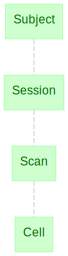

In [21]:
dj.Diagram(schema)

## Composite primary keys with primary dependencies

In [23]:
schema = dj.schema('dimitri_hieararchy2')
schema.drop()
schema = dj.schema('dimitri_hieararchy2')

Proceed to delete entire schema `dimitri_hieararchy2`? [yes, No]: yes


In [24]:
@schema
class Subject(dj.Manual):
    definition = """
    # Experiment Subject
    subject_id : int
    ---
    species = 'mouse' : enum('human', 'mouse', 'rat')
    sex : enum('F', 'M', 'unknown')
    """
    
@schema
class Session(dj.Manual):
    definition = """
    -> Subject
    session_id : int
    ---
    session_timestamp = CURRENT_TIMESTAMP : timestamp
    """
    
@schema
class Scan(dj.Manual):
    definition = """
    -> Session
    scan_id : int
    ---
    laser_power : float  # mW
    """
    
@schema
class Cell(dj.Manual):
    definition = """
    -> Scan
    cell_id : int
    ---
    cell_type : enum('E', 'I')   # excitatory or inhibitory
    """

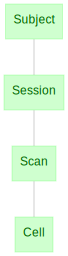

In [25]:
dj.Diagram(schema)

In [26]:
Subject()

subject_id,species,sex


In [27]:
Session()

subject_id,session_id,session_timestamp


In [28]:
Scan()

subject_id,session_id,scan_id,laser_power mW


In [29]:
Cell()

subject_id,session_id,scan_id,cell_id,cell_type excitatory or inhibitory


In [30]:
# Give me cells for subject_id=1

Cell & 'subject_id=1'

subject_id,session_id,scan_id,cell_id,cell_type excitatory or inhibitory


In [31]:
# Give me cells for all males

(Cell & (Subject & 'sex="M"')).make_sql()

'SELECT `subject_id`,`session_id`,`scan_id`,`cell_id`,`cell_type` FROM `dimitri_hieararchy2`.`cell` WHERE((`subject_id`) in (SELECT `subject_id` FROM `dimitri_hieararchy2`.`subject` WHERE(sex="M")))'

In [32]:
Cell * Subject

subject_id,session_id,scan_id,cell_id,cell_type excitatory or inhibitory,species,sex
